In [5]:
import pandas as pd
import numpy as np

import librosa
import librosa.display
import matplotlib.pyplot as plt
from matplotlib import cm

import io, base64
import os, sys

import IPython
import pickle

from tensorflow.python.ops import gen_audio_ops as contrib_audio

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from keras import backend as K 

import random 
import glob

train_dataset_path = '../data/csv/train_data.csv'
valid_dataset_path = '../data/csv/valid_data.csv'
#test_dataset_path = '../data/csv/test_data.csv'
test_dataset_path = '../data/csv/wt_data.csv'

SAMPLING_RATE = 16000
MIN_FREQ = 100
MAX_FREQ = SAMPLING_RATE//2
WIN_SIZE_MS = 0.02
WIN_INCREASE_MS = 0.02
NUM_CEPSTRAL = 10

In [2]:
test_data = pd.read_csv(test_dataset_path)
test_data.head()

,Unnamed: 0,path,speakerId,transcription,action,object,location
0,0,wavs/wt_data/Bring_me_my_socks_325311.wav,NaN,Bring me my socks,bring,socks,none
1,1,wavs/wt_data/Bring_me_my_socks_872611.wav,NaN,Bring me my socks,bring,socks,none
2,2,wavs/wt_data/Bring_me_some_juice_147104.wav,NaN,Bring me some juice,bring,juice,none
3,3,wavs/wt_data/Bring_me_some_juice_184605.wav,NaN,Bring me some juice,bring,juice,none
4,4,wavs/wt_data/Bring_me_some_juice_336204.wav,NaN,Bring me some juice,bring,juice,none


In [3]:
def generate_features(draw_graphs, raw_data, sampling_freq,
                      frame_length, frame_stride, num_filters, 
                      num_cepstral, low_frequency, high_frequency):
    graphs = []
    
    raw_data = np.expand_dims(raw_data, axis = -1)
    window_size = int(sampling_freq * frame_length)
    stride = int(sampling_freq * frame_stride)
    
    spectrogram = contrib_audio.audio_spectrogram(
        raw_data,
        window_size=window_size,
        stride=stride,
        magnitude_squared=True)
    
    mfcc = contrib_audio.mfcc(
        spectrogram,
        sampling_freq,
        dct_coefficient_count=num_cepstral,
        upper_frequency_limit=high_frequency, 
        lower_frequency_limit=low_frequency)
    
    mfcc = np.squeeze(mfcc)

    if draw_graphs:
        mfcc_graph = np.swapaxes(mfcc, 0, 1)
        fig, ax = plt.subplots()
        img = librosa.display.specshow(mfcc_graph, x_axis='time', ax=ax)
        fig.colorbar(img, ax=ax)
        ax.set(title='MFCC')
        buf = io.BytesIO()

        plt.savefig(buf, format='svg', bbox_inches='tight', pad_inches=0)

        buf.seek(0)
        image = (base64.b64encode(buf.getvalue()).decode('ascii'))

        buf.close()

        graphs.append({
            'name': 'Cepstral Coefficients',
            'image': image,
            'imageMimeType': 'image/svg+xml',
            'type': 'image'
        })

    return {
        'features': mfcc,
        'graphs': graphs,
        'output_config': {
            'type': 'spectrogram',
            'shape': {
                'width': mfcc.shape[1],
                'height': mfcc.shape[0]
            }
        }
    }

['conv2d', 'conv2d_1', 'conv2d_2', 'conv2d_3', 'conv2d_4']
conv2d


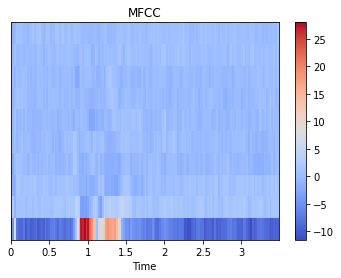

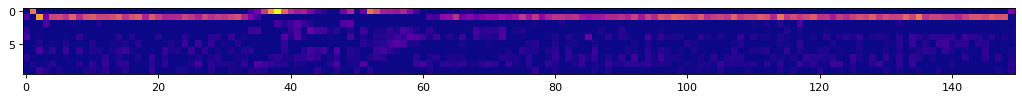

conv2d


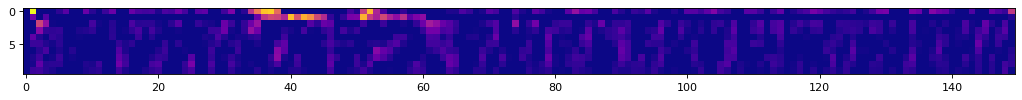

conv2d


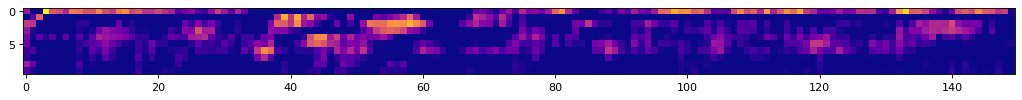

conv2d


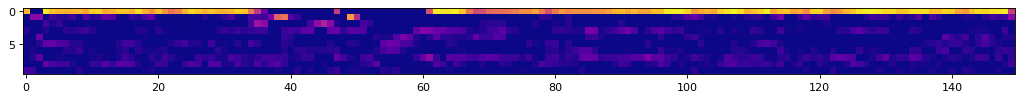

conv2d


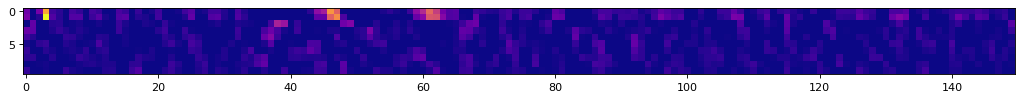

conv2d


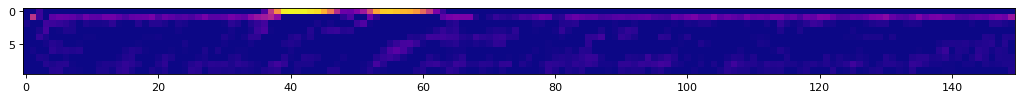

conv2d


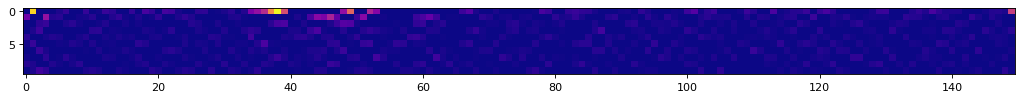

conv2d


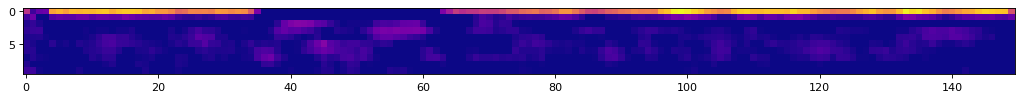

conv2d


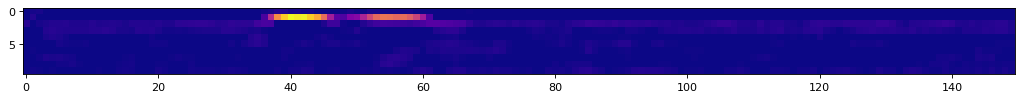

conv2d


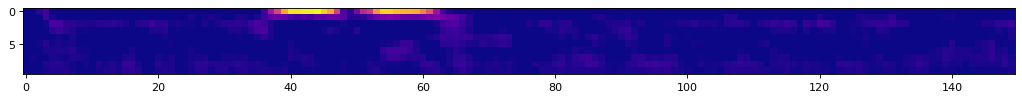

conv2d


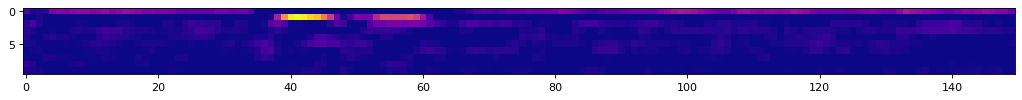

conv2d


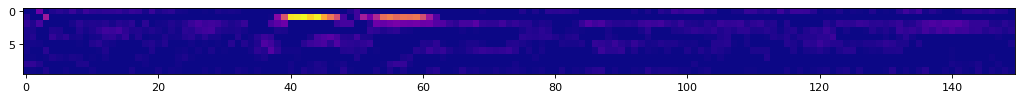

conv2d


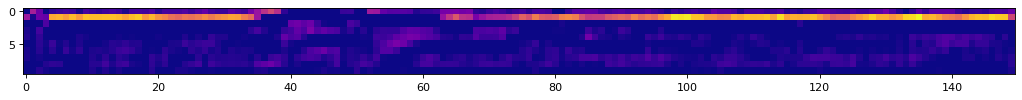

conv2d


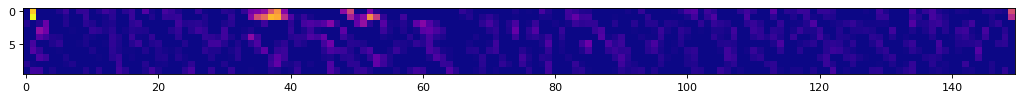

conv2d


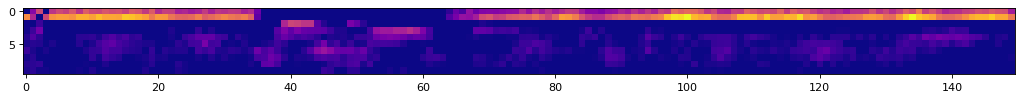

conv2d


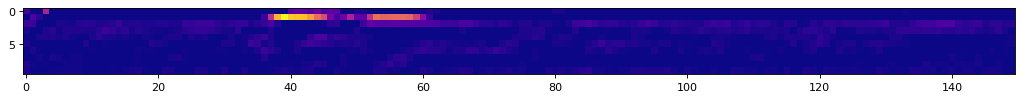

conv2d_1


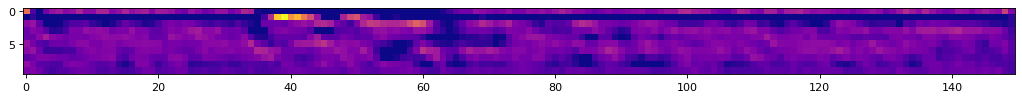

conv2d_1


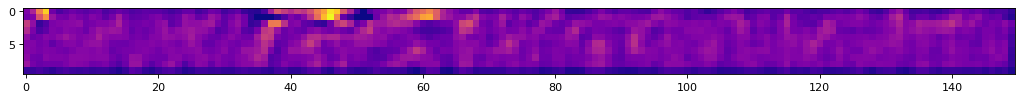

conv2d_1


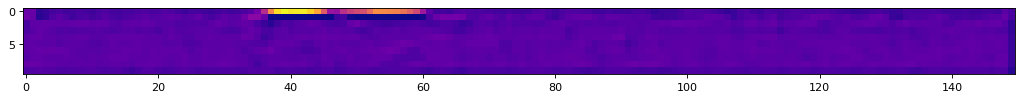

conv2d_1


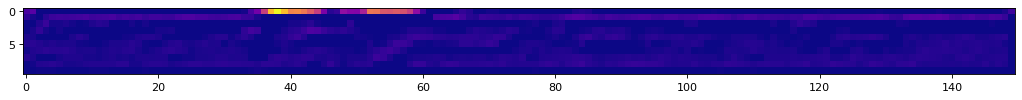

conv2d_1


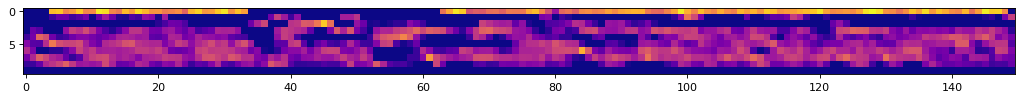

conv2d_1


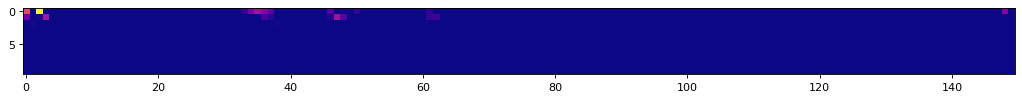

conv2d_1


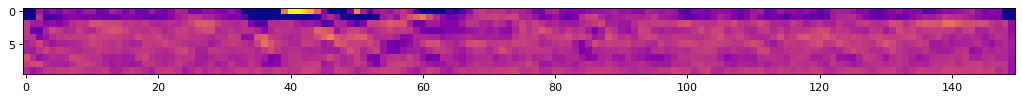

conv2d_1


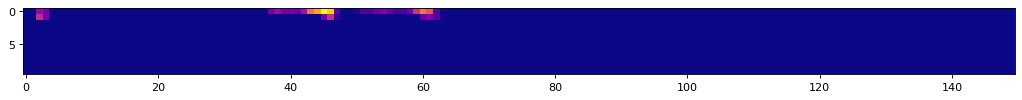

conv2d_1


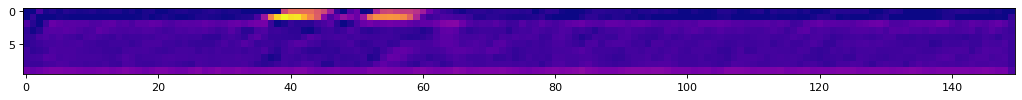

conv2d_1


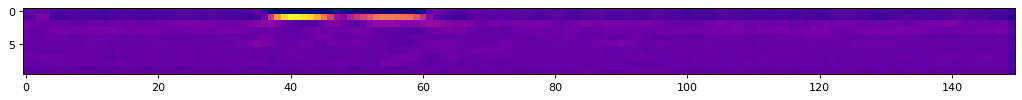

conv2d_1


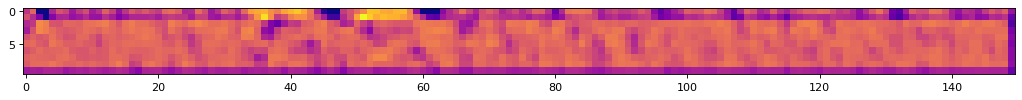

conv2d_1


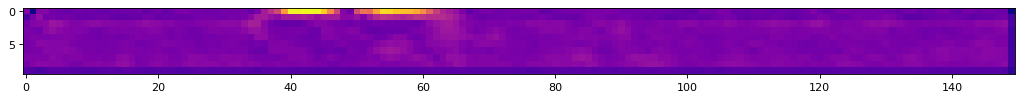

conv2d_1


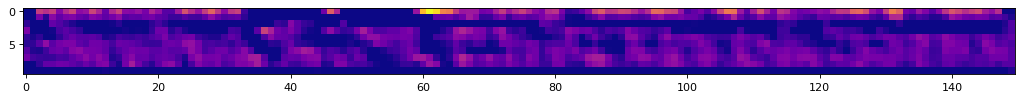

conv2d_1


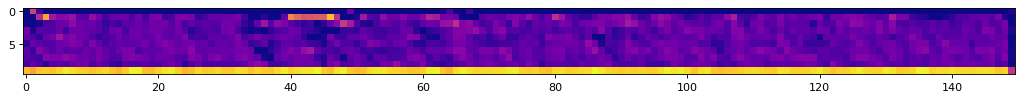

conv2d_1


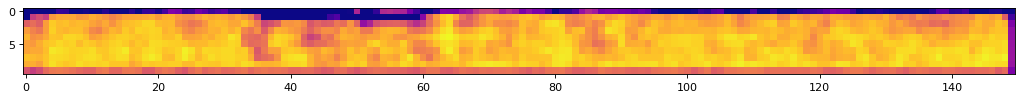

conv2d_1


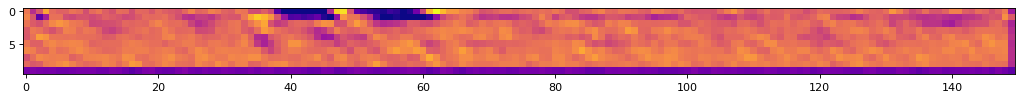

conv2d_2


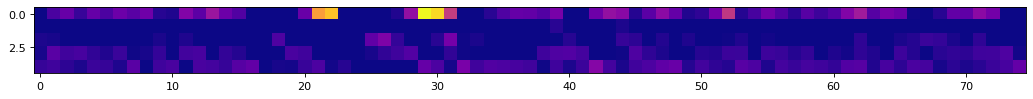

conv2d_2


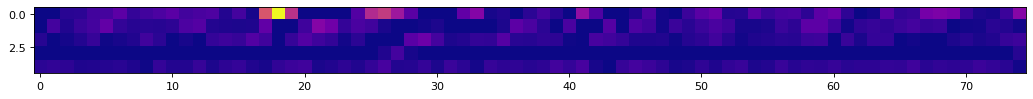

conv2d_2


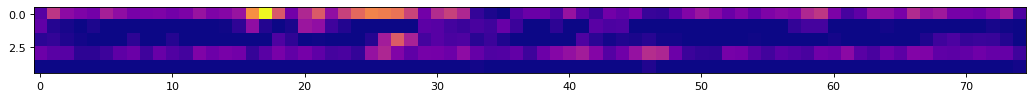

conv2d_2


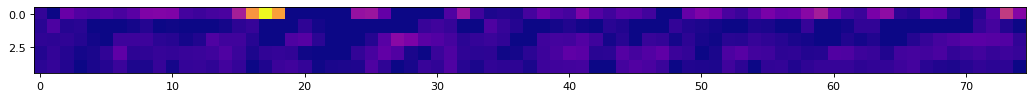

conv2d_2


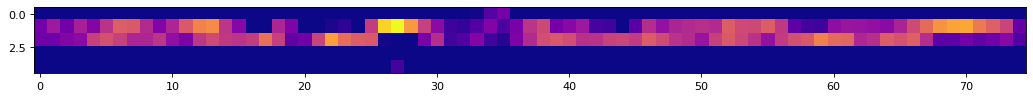

conv2d_2


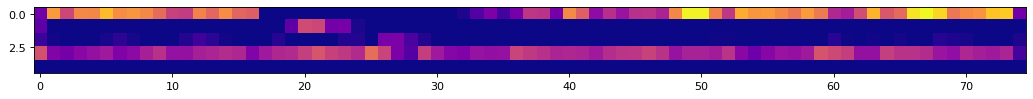

conv2d_2


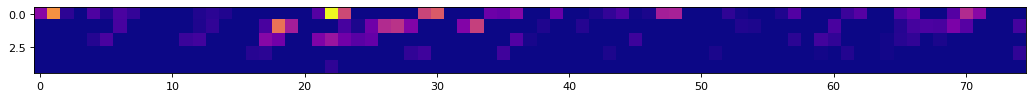

conv2d_2


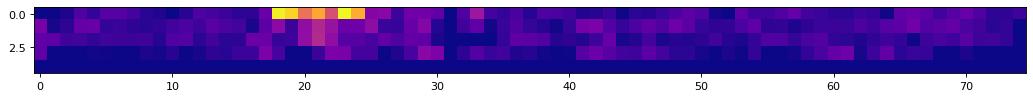

conv2d_2


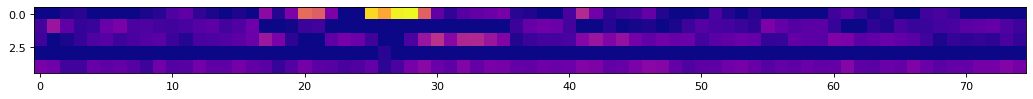

conv2d_2


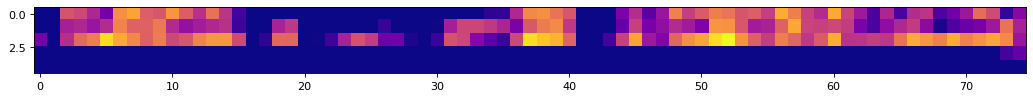

conv2d_2


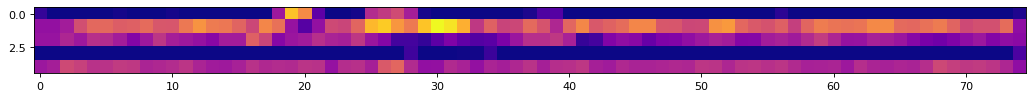

conv2d_2


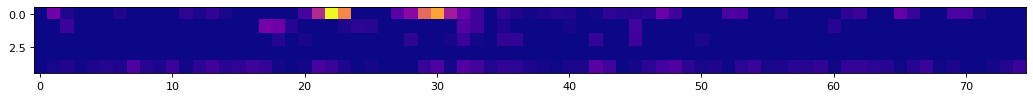

conv2d_2


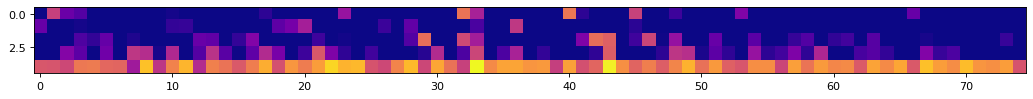

conv2d_2


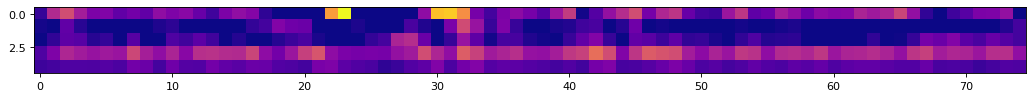

conv2d_2


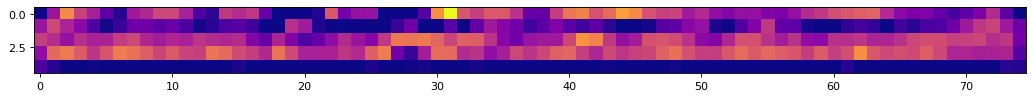

conv2d_2


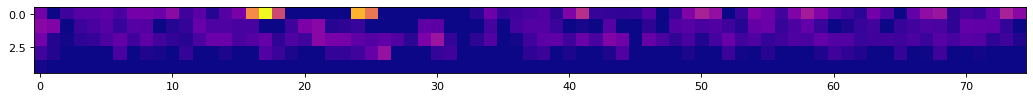

conv2d_3


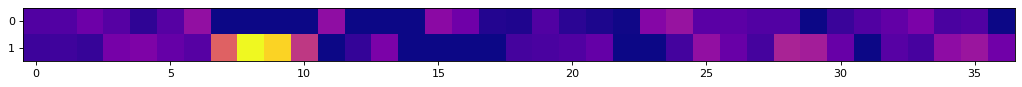

conv2d_3


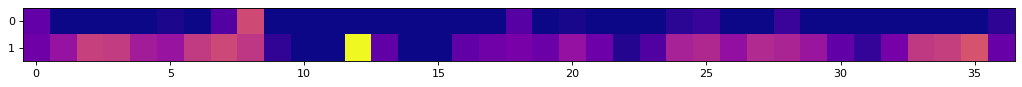

conv2d_3


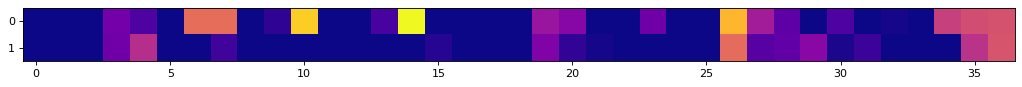

conv2d_3


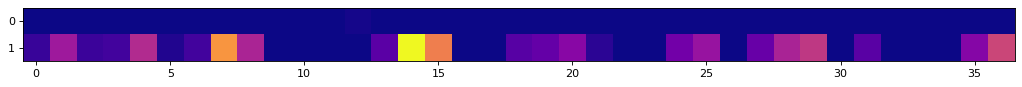

conv2d_3


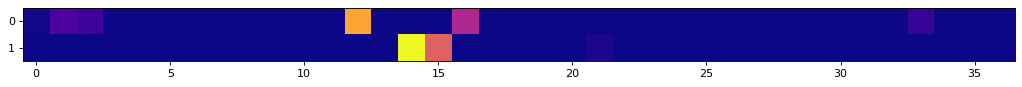

conv2d_3


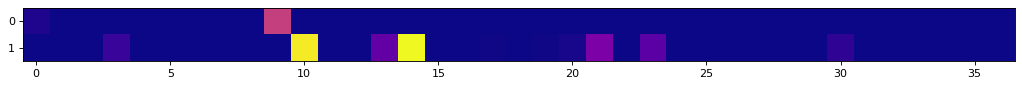

conv2d_3


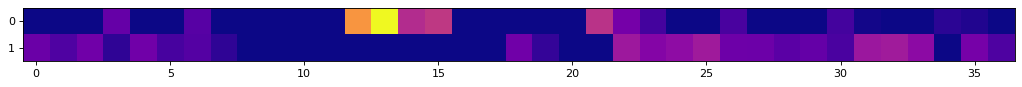

conv2d_3


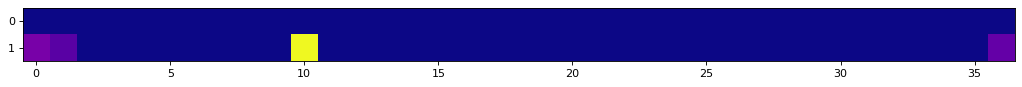

conv2d_3


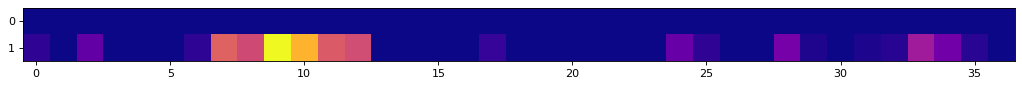

conv2d_3


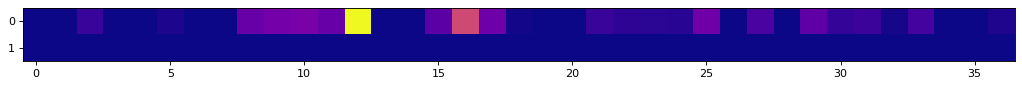

conv2d_3


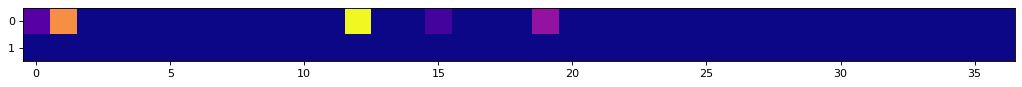

conv2d_3


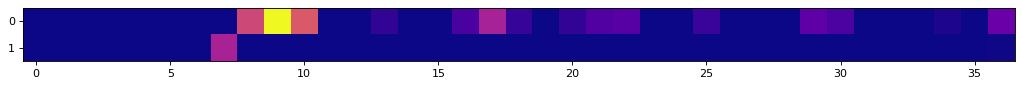

conv2d_3


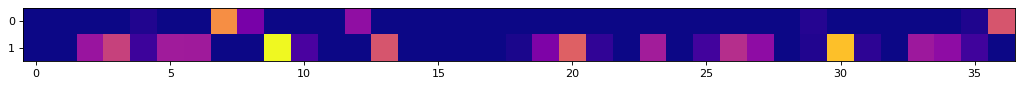

conv2d_3


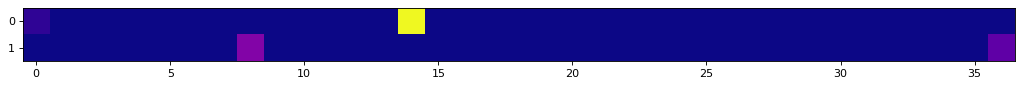

conv2d_3


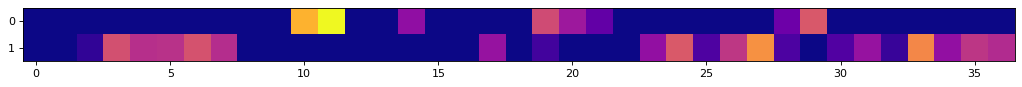

conv2d_3


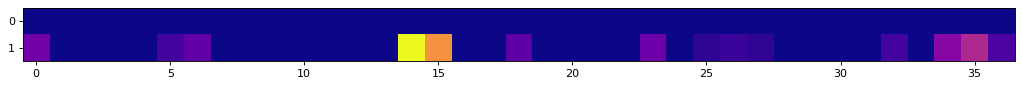

conv2d_4


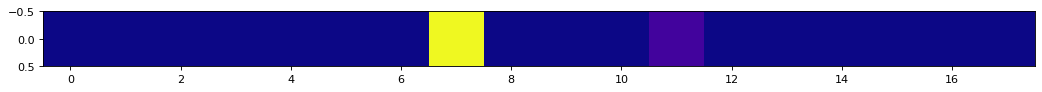

conv2d_4


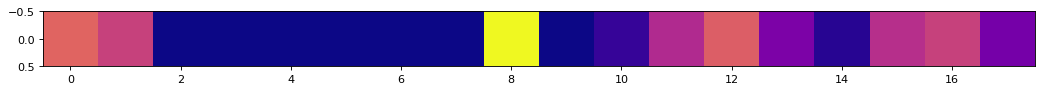

conv2d_4


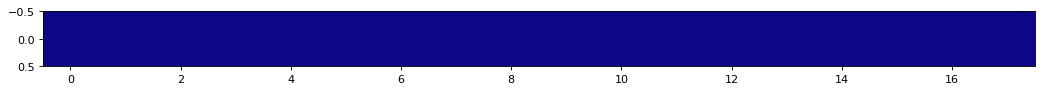

conv2d_4


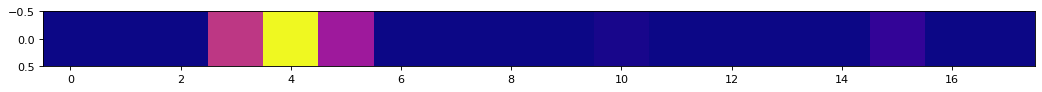

conv2d_4


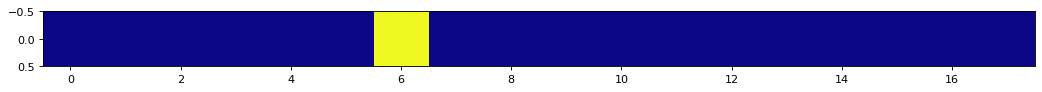

conv2d_4


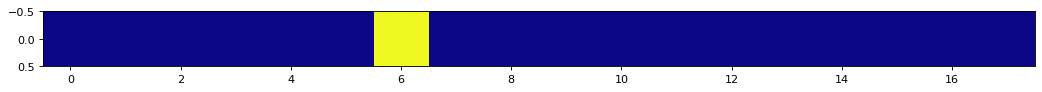

conv2d_4


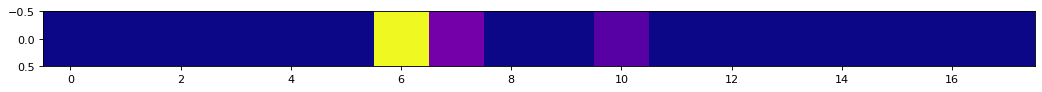

conv2d_4


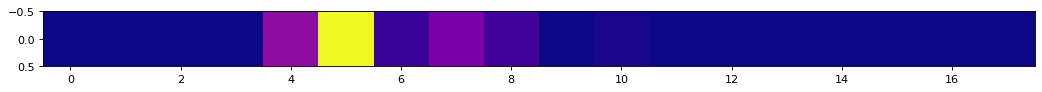

conv2d_4


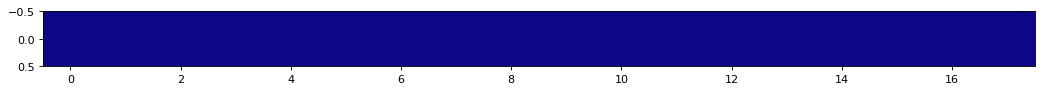

conv2d_4


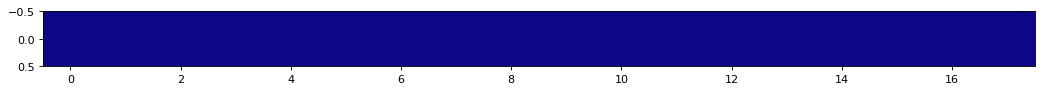

conv2d_4


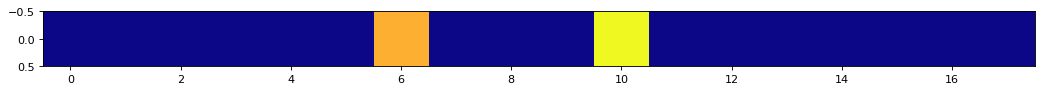

conv2d_4


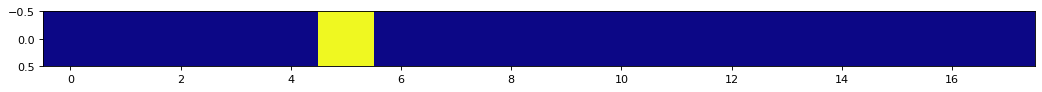

conv2d_4


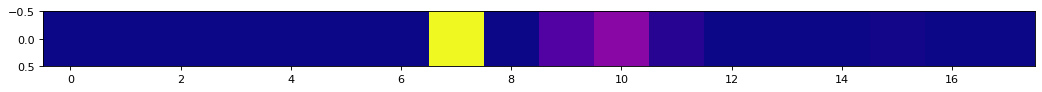

conv2d_4


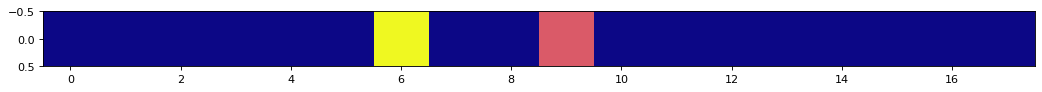

conv2d_4


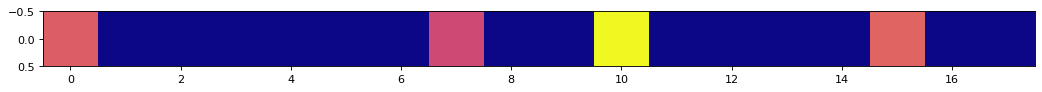

conv2d_4


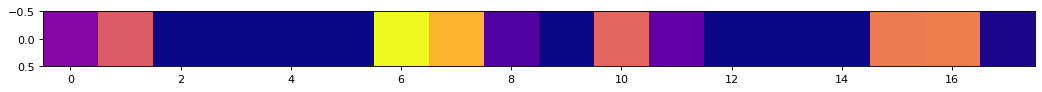

In [15]:
from matplotlib.pyplot import figure

model_name = "/home/ubuntu/github/Speech-to-Intent-Micro/checkpoints/2021-08-20_18-02-16_rc1/slu_model.h5"
model = tf.keras.models.load_model(model_name)

prefix = ["..", "data"]
wav_file = os.path.join(*prefix, test_data['path'][0])

audio, sample_rate = librosa.load(wav_file, sr=16000, res_type='kaiser_best')
audio = librosa.util.fix_length(audio, 16000*3)
features = generate_features(True, audio, SAMPLING_RATE, 
                  WIN_SIZE_MS, WIN_INCREASE_MS, 32, 
                  NUM_CEPSTRAL, MIN_FREQ, MAX_FREQ)

features = features['features']
X = np.expand_dims(features, axis = 0)

vis_layers = []

for layer in model.layers:
    if "conv" in layer.name:
        vis_layers.append(layer.name)

print(vis_layers)

outputs = [model.get_layer(i).output for i in vis_layers]
vis_model = Model(inputs=model.inputs, outputs=outputs)

feature_maps = vis_model(X, training=False)

# plot the output from each block
square = 4

for i, fmap in enumerate(feature_maps):

    ix = 1
    for _ in range(square):
        for _ in range(square):
            figure(figsize=(16, 8), dpi=80)
            graph = np.swapaxes(fmap, 1, 2)
            print(vis_layers[i])
            plt.imshow(graph[0, :, :, ix-1], cmap='plasma')
            ix += 1
            # show the figure
            plt.show()

IPython.display.Audio(wav_file)